# Comparison of MEFISTO and PRISMO on Visium Data from MEFISTO paper

In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from data_loader import load_mefisto_visium
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr

# from mofapy2.run.entry_point import entry_point
from famo.utils_downstream import match
from famo.utils_io import load_model

In [2]:
adata = load_mefisto_visium()

## MEFISTO

In [3]:
# ent = entry_point()
# ent.set_data_options(use_float32=True)
# ent.set_data_from_anndata(adata)
# ent.set_model_options(factors=4)
# ent.set_train_options()
# ent.set_train_options(seed=54321)
# n_inducing = 1000

# ent.set_covariates([adata.obsm["spatial"]], covariates_names=["imagerow", "imagecol"])
# ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing / adata.n_obs, start_opt=10, opt_freq=10)
# ent.build()
# ent.run()

# expectations = ent.model.getExpectations()
# ent.save("results/mefisto.hdf5")

mefisto_model = h5py.File("results/mefisto.hdf5", "r")

In [4]:
z_mefisto = mefisto_model["expectations"]["Z"]["group1"][:].T
w_mefisto = mefisto_model["expectations"]["W"]["rna"][:].T

## PRISMO

In [5]:
# model = CORE(device="cuda:0")
# model.fit(
#     data=adata,
#     n_factors=4,
#     weight_prior="Horseshoe",
#     factor_prior="GP",
#     likelihoods="Normal",
#     covariates_obsm_key="spatial",
#     early_stopper_patience=500,
#     lr=5e-2,
#     plot_data_overview=False,
#     save_path="results/prismo",
#     gp_n_inducing=1000,
#     seed=5432,
#     init_factors="pca"
# )

prismo_model = load_model("results/prismo")

Model loaded from results/prismo/model.pkl
Parameters loaded from results/prismo/params.save


In [6]:
z_prismo = prismo_model.get_factors()['group_1'].values
w_prismo = prismo_model.get_weights()['view_1'].T.values

## Factor Matching

In [7]:
z_inds, z_signs = match(z_mefisto, z_prismo, dim=-1)

z_prismo = z_prismo[:, z_inds]
z_prismo = z_prismo * z_signs.reshape(1, -1)

w_prismo = w_prismo[:, z_inds]
w_prismo = w_prismo * z_signs.reshape(1, -1)

z_prismo = z_prismo / np.ptp(z_prismo, axis=0, keepdims=True)
z_mefisto = z_mefisto / np.ptp(z_mefisto, axis=0, keepdims=True)

w_prismo = w_prismo / np.ptp(w_prismo, axis=0, keepdims=True)
w_mefisto = w_mefisto / np.ptp(w_mefisto, axis=0, keepdims=True)

corr = []
for factor in range(z_prismo.shape[1]):
    corr.append(pearsonr(z_prismo[:, factor], z_mefisto[:, factor])[0])
corr = np.array(corr)
factor_order = corr.argsort()[::-1]
corr = corr[factor_order]

z_prismo = z_prismo[:, factor_order]
w_prismo = w_prismo[:, factor_order]

z_mefisto = z_mefisto[:, factor_order]
w_mefisto = w_mefisto[:, factor_order]

## Plots

In [64]:
def plot_factors(z_prismo, z_other, x, name_other: str, save_path=None, s: int=10, figsize=(20, 10)):
    n_factors = z_prismo.shape[-1]

    if np.all(z_prismo >= 0) and np.all(z_other >= 0):
        nonnegative = True
        cmap = ListedColormap(plt.get_cmap('vlag_r')(np.linspace(0.5, 1, 256)))
    else:
        nonnegative = False
        cmap = plt.get_cmap('vlag_r')

    fig, axs = plt.subplots(3, n_factors, figsize=figsize, gridspec_kw={'height_ratios': [1, 1, 0.1]})

    for factor in range(n_factors):
        if nonnegative:
            prismo_norm = "linear"
            other_norm = "linear"
        else:
            prismo_norm = TwoSlopeNorm(vcenter=0, vmin=z_prismo[:, factor].min(), vmax=z_prismo[:, factor].max())
            other_norm = TwoSlopeNorm(vcenter=0, vmin=z_other[:, factor].min(), vmax=z_other[:, factor].max())

        sc_prismo = axs[0][factor].scatter(x[:, 0], -1 * x[:, 1], s=s, c=z_prismo[:, factor], cmap=cmap, zorder=2, norm=prismo_norm, rasterized=True)
        sc_other = axs[1][factor].scatter(x[:, 0], -1 * x[:, 1], s=10, c=z_other[:, factor], cmap=cmap, zorder=1, norm=other_norm, rasterized=True)

        divider_prismo = make_axes_locatable(axs[0][factor])
        divider_other = make_axes_locatable(axs[1][factor])
        cax_prismo = divider_prismo.append_axes("bottom", size="5%", pad=0.1)
        cax_other = divider_other.append_axes("bottom", size="5%", pad=0.1)
        cbar_prismo = fig.colorbar(sc_prismo, cax=cax_prismo, orientation='horizontal')
        cbar_other = fig.colorbar(sc_other, cax=cax_other, orientation='horizontal')
        if nonnegative:
            cbar_prismo.ax.set_xticks([0.0, 2 * z_prismo[:, factor].max() / 3])
            cbar_prismo.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.0e}')
            cbar_other.ax.set_xticks([0.0, 2 * z_other[:, factor].max() / 3])
            cbar_other.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.0e}')
        else:
            cbar_prismo.ax.set_xticks([z_prismo[:, factor].min(), z_prismo[:, factor].max()])
            cbar_other.ax.set_xticks([z_other[:, factor].min(), z_other[:, factor].max()])

        axs[0][factor].set_title(f"Factor {factor + 1}")

        for i in range(2):
            ax = axs[i][factor]
            ax.grid(which='both', zorder=0, alpha=0.5)
            ax.set_aspect(1.)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='both', which='both', length=0)

        # Correlation bar
        ax = axs[2][factor]
        corr = round(pearsonr(z_prismo[:, factor], z_other[:, factor])[0], 2)
        ax.axis("off")
        ax.barh([0], [1], color='darkgray', height=1)
        ax.barh([0], [corr], color=plt.get_cmap("vlag_r")(0), height=1)
        ax.text(0.5, 0, f'R={corr:.2f}', va='center', ha='center', color='white', transform=ax.transData)
        ax.set_xticks([])
        ax.set_yticks([])

    axs[0, 0].set_ylabel("PRISMO", fontsize=12)
    axs[1, 0].set_ylabel(name_other, fontsize=12)

    plt.tight_layout()
    if save_path is not None:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path, transparent=True, dpi=300)

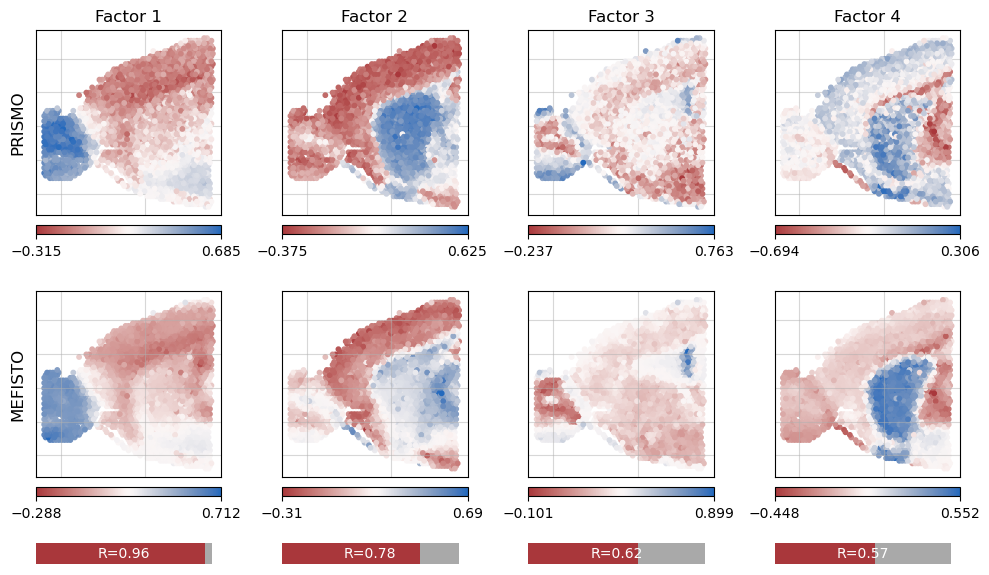

In [65]:
plot_factors(z_prismo, z_mefisto, x=adata.obsm["spatial"], name_other="MEFISTO", save_path="plots/factors.svg", s=10, figsize=(10, 6))

In [59]:
def plot_weights(w_1, w_2, save_path=None):
    fig, axs = plt.subplots(2, w_1.shape[1], figsize=(20, 6.), gridspec_kw={'height_ratios': [1, 0.1]})

    for factor in range(w_1.shape[1]):
        ax = axs[0][factor]
        ax.scatter(w_1[:, factor], w_2[:, factor], s=1, zorder=2, rasterized=True)
        ax.set_title(f"Factor {factor + 1}")
        ax.grid(which='both', zorder=0, alpha=0.5)
        ax.set_aspect(1.)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xlabel("PRISMO")
        ax.set_ylabel("MEFISTO")

        ax = axs[1][factor]
        corr = round(pearsonr(w_1[:, factor], w_2[:, factor])[0], 2)
        ax.axis("off")
        ax.barh([0], [1], color='darkgray', height=1)
        ax.barh([0], [corr], color=plt.get_cmap("vlag_r")(0), height=1)
        ax.text(0.5, 0, f'R={corr:.2f}', va='center', ha='center', color='white', transform=ax.transData)
        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(1, 4):
        axs[0, i].set_yticklabels([])
        axs[0, i].set_ylabel("")

    plt.tight_layout()
    if save_path is not None:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path, transparent=True)

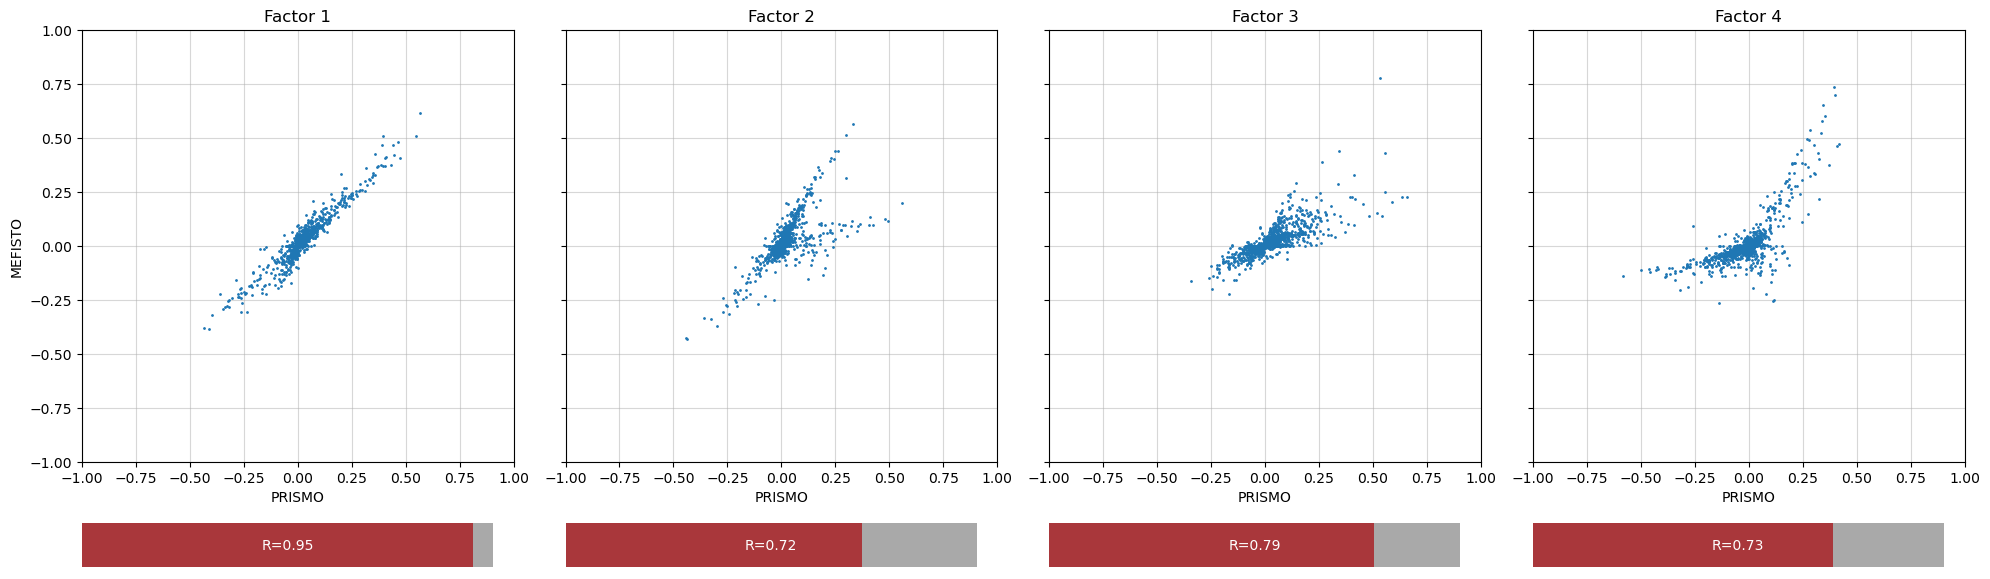

In [62]:
plot_weights(w_prismo.T, w_mefisto.T, save_path="weights.svg")